In [8]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 

from astropy.table import Table, Column, vstack, join

import numpy as np 
from numpy.lib.recfunctions import append_fields

import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 25})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### HSC data

* **1-D stellar mass**: `s16a_wide2_massive_fsps1_imgsub_use_short.fits`

In [2]:
s16a_dir = '/Users/song/data/massive/dr16a/'

logm_sbp = Table.read(
    os.path.join(s16a_dir, 'sbp/catalog', 's16a_wide2_massive_fsps1_imgsub_use_short.fits'))

print('# 1-D stellar mass: {}'.format(len(logm_sbp)))

logm_cmod = Table.read(
    os.path.join(s16a_dir, 'galaxy', 's16a_wide_sed_cmodel_mass.fits'))

print('# CModel stellar mass: {}'.format(len(logm_cmod)))

# 1-D stellar mass: 38653
# CModel stellar mass: 684049


In [68]:
# Only keep the useful columns
logm_sbp_use = logm_sbp[
    'object_id', 'logm_10', 'logm_100', 'logm_max'
]

logm_cmod_use = logm_cmod[
    'object_id', 'ra', 'dec', 'z_best', 'z_spec', 
    'gcmodel_mag', 'rcmodel_mag', 'icmodel_mag', 'zcmodel_mag',
    'icmodel_flux', 'iparent_flux_convolved_2_2',
    'MSTAR', 'MSTAR_ERR', 'TAU',
    'ABSMAG_G', 'ABSMAG_R', 'ABSMAG_I', 'ABSMAG_Z',
]

# Rename a few columns to be consistent
logm_cmod_use.rename_column('MSTAR', 'logm_cmod')
logm_cmod_use.rename_column('MSTAR_ERR', 'logm_err')
logm_cmod_use.rename_column('TAU', 'tau_ised')
logm_cmod_use.rename_column('ABSMAG_G', 'amag_g_ised')
logm_cmod_use.rename_column('ABSMAG_R', 'amag_r_ised')
logm_cmod_use.rename_column('ABSMAG_I', 'amag_i_ised')
logm_cmod_use.rename_column('ABSMAG_Z', 'amag_z_ised')
logm_cmod_use.rename_column('iparent_flux_convolved_2_2', 'iaper2_flux')

# Join the table
logm_both = join(logm_cmod_use, logm_sbp_use, keys='object_id', join_type='left')

logm_both['logm_10'].fill_value = np.nan
logm_both['logm_100'].fill_value = np.nan
logm_both['logm_max'].fill_value = np.nan
logm_both = logm_both.filled()

# Two galaxies with failed SED fitting, hence no CModel mass. Exclude them.
logm_both = logm_both[np.isfinite(logm_both['logm_cmod'])]

# Make sure all 1-D mass are matched
assert np.isfinite(logm_both['logm_max']).sum() == len(logm_sbp)

# Estimate an aperture mass
logm_aper = logm_both['logm_cmod'] + np.log10(logm_both['iaper2_flux'] / logm_both['icmodel_flux'])
logm_both.add_column(Column(data=logm_aper, name='logm_aper'))

# Empty columns for the "best" stellar mass and additional uncertainties
logm_both.add_column(Column(data=np.full(len(logm_both), np.nan), name='logm_best'))
logm_both.add_column(Column(data=np.zeros(len(logm_both)), name='sigm_extra'))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


In [69]:
# Exclude outliers, just for making figures
color_mask = ((logm_both['gcmodel_mag'] - logm_both['rcmodel_mag'] > 0.5) &
              (logm_both['gcmodel_mag'] - logm_both['rcmodel_mag'] < 2.3) &
              (logm_both['rcmodel_mag'] - logm_both['icmodel_mag'] > 0.2) &
              (logm_both['rcmodel_mag'] - logm_both['icmodel_mag'] < 1.3) &
              (logm_both['icmodel_mag'] - logm_both['zcmodel_mag'] > 0.0) &
              (logm_both['icmodel_mag'] - logm_both['zcmodel_mag'] < 0.7) &
              (logm_both['amag_g_ised'] - logm_both['amag_r_ised'] > 0.1) &
              (logm_both['amag_g_ised'] - logm_both['amag_r_ised'] < 1.1) &
              (logm_both['amag_r_ised'] - logm_both['amag_z_ised'] > 0.1) &
              (logm_both['amag_r_ised'] - logm_both['amag_z_ised'] < 1.1) &
              (logm_both['amag_g_ised'] - logm_both['amag_i_ised'] > 0.4) &
              (logm_both['amag_g_ised'] - logm_both['amag_i_ised'] < 1.5) &
              np.isfinite(logm_both['amag_g_ised'] - logm_both['amag_r_ised']) &
              np.isfinite(logm_both['amag_g_ised'] - logm_both['amag_i_ised']) &
              np.isfinite(logm_both['amag_r_ised'] - logm_both['amag_z_ised'])
             )

logm_use = logm_both[color_mask]

### Explore the difference between 1-D and CModel mass

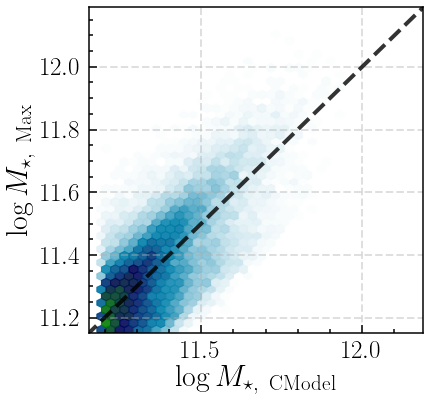

In [9]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)


ax1.hexbin(logm_use['logm_cmod'], logm_use['logm_max'],
           alpha=0.9, gridsize=(35, 35), cmap='ocean_r', rasterized=True)

ax1.plot([11.0, 12.5], [11.0, 12.5], linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(11.15, 12.19)
_ = ax1.set_ylim(11.15, 12.19)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm CModel}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max}$', fontsize=30)

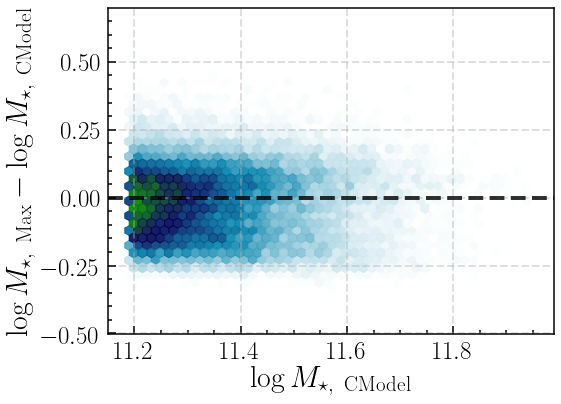

In [73]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['logm_cmod'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 20), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(11.15, 11.99)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm CModel}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

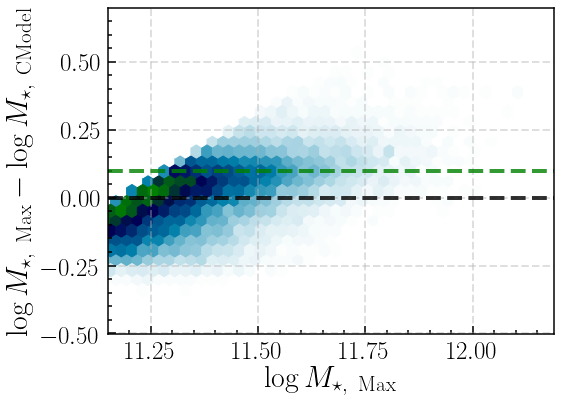

In [74]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.axhline(0.1, linewidth=4.0, linestyle='--', c='g', alpha=0.8)

ax1.hexbin(logm_use['logm_max'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=1.0, gridsize=(60, 15), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(11.15, 12.19)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm Max}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

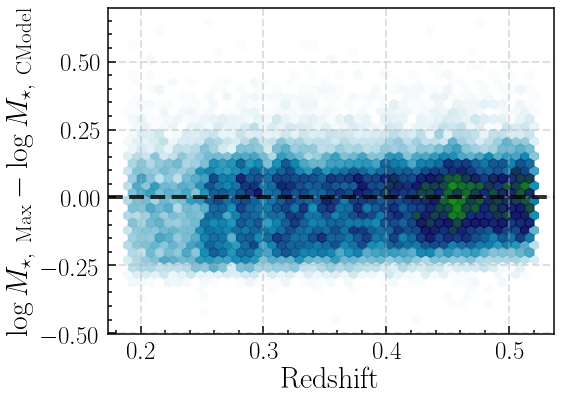

In [75]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['z_best'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(45, 20), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

#_ = ax1.set_xlim(0.09, 25)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\rm Redshift$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

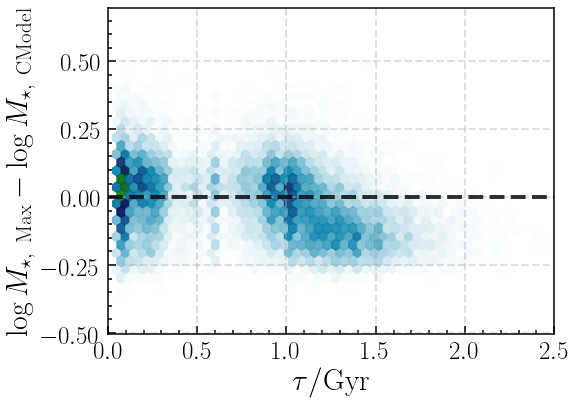

In [76]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['tau_ised'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(0.0, 2.5)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\tau/\rm Gyr$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

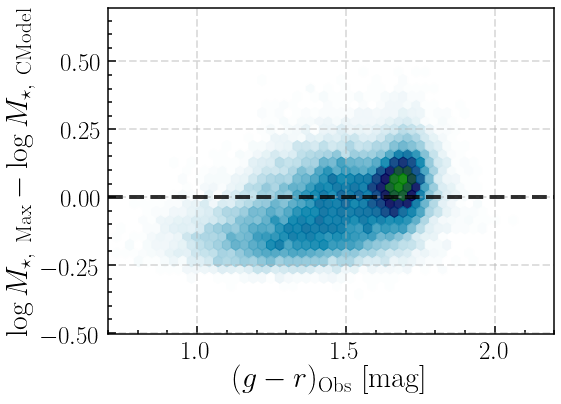

In [77]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['gcmodel_mag'] - logm_use['rcmodel_mag'], 
           logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(0.7, 2.2)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$(g-r)_{\rm Obs}\ [\rm mag]$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

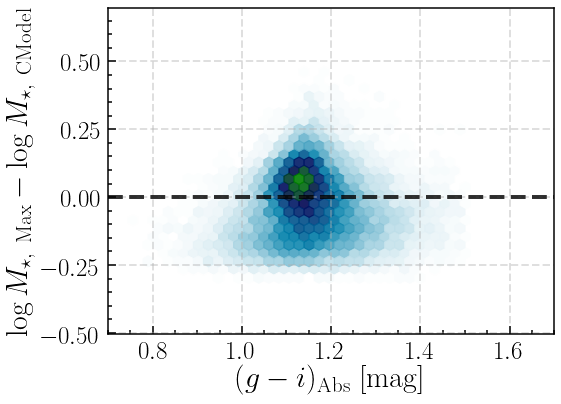

In [80]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['amag_g_ised'] - logm_use['amag_i_ised'], 
           logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(40, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(0.7, 1.7)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$(g-i)_{\rm Abs}\ [\rm mag]$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

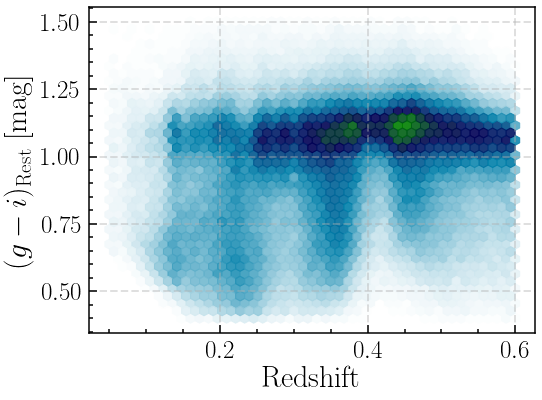

In [86]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

#ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['z_best'],
           (logm_use['amag_g_ised'] - logm_use['amag_i_ised']),
           alpha=0.9, gridsize=(45, 20), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

#_ = ax1.set_xlim(0.7, 2.2)
#_ = ax1.set_ylim(0.15, 1.79)

_ = ax1.set_ylabel(r'$(g-i)_{\rm Rest}\ [\rm mag]$', fontsize=30)
_ = ax1.set_xlabel(r'$\rm Redshift$', fontsize=30)

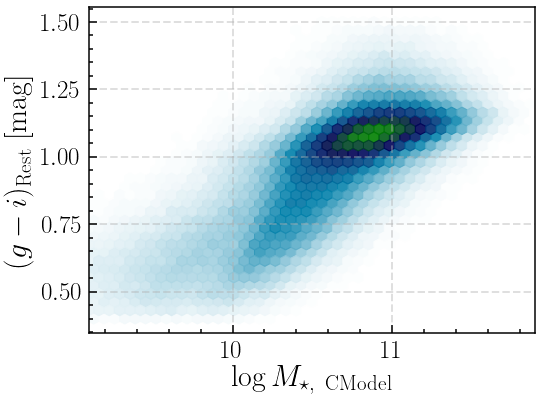

In [90]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

#ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['logm_cmod'],
           (logm_use['amag_g_ised'] - logm_use['amag_i_ised']),
           alpha=0.9, gridsize=(65, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(9.1, 11.9)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_ylabel(r'$(g-i)_{\rm Rest}\ [\rm mag]$', fontsize=30)
_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm CModel}$', fontsize=30)

#### Look into the aperture mass

* Just assume the constant M/L

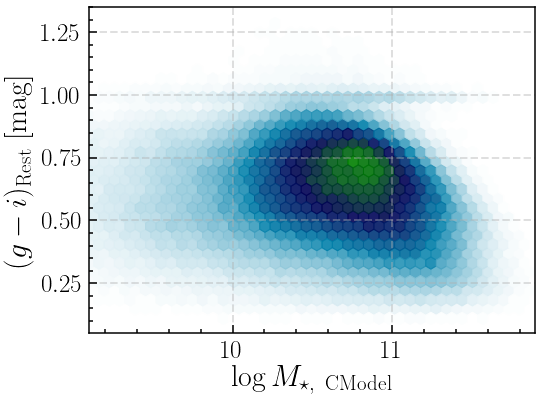

In [102]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

#ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['logm_cmod'],
           (logm_use['iaper2_flux'] / logm_use['icmodel_flux']),
           alpha=0.9, gridsize=(65, 70), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(9.1, 11.9)
_ = ax1.set_ylim(0.05, 1.35)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm CModel}$', fontsize=30)
_ = ax1.set_ylabel(r'$(g-i)_{\rm Rest}\ [\rm mag]$', fontsize=30)

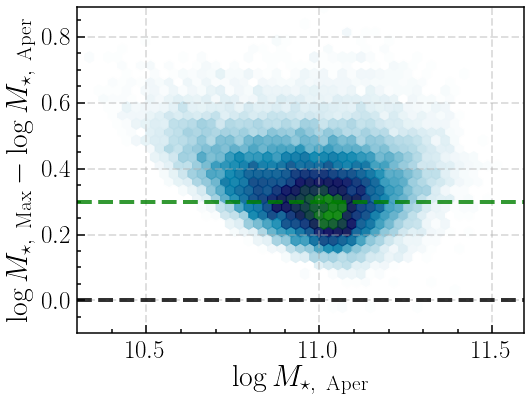

In [113]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)
ax1.axhline(0.3, linewidth=4.0, linestyle='--', c='g', alpha=0.8)

ax1.hexbin(logm_use['logm_aper'], logm_use['logm_max'] - logm_use['logm_aper'],
           alpha=0.9, gridsize=(50, 25), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(10.3, 11.59)
_ = ax1.set_ylim(-0.1, 0.89)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm Aper}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm Aper}$', fontsize=30)

In [70]:
# Sample with useful 1-D mass
flag_oned = np.isfinite(logm_both['logm_max']) & (logm_both['logm_aper'] > 0)

# Aperture-based correction
flag_aper = ~flag_oned & (logm_both['logm_aper'] > 0)

# CModel-based correction
flag_cmod = ~flag_oned & ~flag_aper

print(flag_oned.sum(), flag_aper.sum(), flag_cmod.sum())
assert flag_oned.sum() + flag_aper.sum() + flag_cmod.sum() == len(logm_both)
                                                   
# Seperate samples
gal_oned= logm_both[flag_oned]
gal_oned['logm_best'] = gal_oned['logm_max']

gal_cmod = logm_both[flag_cmod]
gal_cmod['logm_best'] = gal_cmod['logm_cmod'] + 0.1
gal_cmod['sigm_extra'] = 0.1

gal_aper = logm_both[flag_aper]

38649 645378 20


In [71]:
aper_cut = gal_oned['logm_aper'] >= 10.9

mass_aper = gal_oned[aper_cut]['logm_aper']
diff_aper = gal_oned[aper_cut]['logm_max'] - mass_aper

logm_bin = np.linspace(10.95, 11.65, 9)
idx_diff = np.digitize(mass_aper, logm_bin)

med_mass = [np.nanmedian(mass_aper[idx_diff == k]) for k in range(len(logm_bin))]
# Median mass difference
med_diff = [np.nanmedian(diff_aper[idx_diff == k]) for k in range(len(logm_bin))]
# Mean mass difference
avg_diff = [np.nanmean(diff_aper[idx_diff == k]) for k in range(len(logm_bin))]
# Scatter of mass difference
std_diff = [np.nanstd(diff_aper[idx_diff == k]) for k in range(len(logm_bin))]

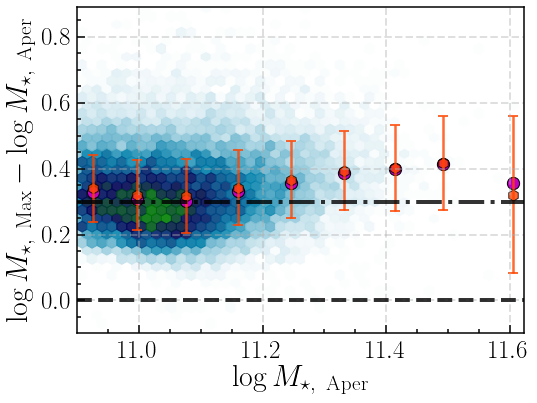

In [72]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)
ax1.axhline(0.3, linewidth=4.0, linestyle='-.', c='k', alpha=0.8)

ax1.hexbin(mass_aper, diff_aper,
           alpha=0.9, gridsize=(45, 25), cmap='ocean_r', rasterized=True)

ax1.scatter(med_mass, med_diff, facecolor='m', edgecolor='k', s=150)
ax1.scatter(med_mass, avg_diff, facecolor='orangered', edgecolor='k', s=120, 
            alpha=0.8, marker='h')

ax1.errorbar(med_mass, avg_diff, yerr=std_diff, 
             fmt='h', ecolor='orangered', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

#_ = ax1.set_xlim(10.3, 11.59)
_ = ax1.set_ylim(-0.1, 0.89)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm Aper}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm Aper}$', fontsize=30)

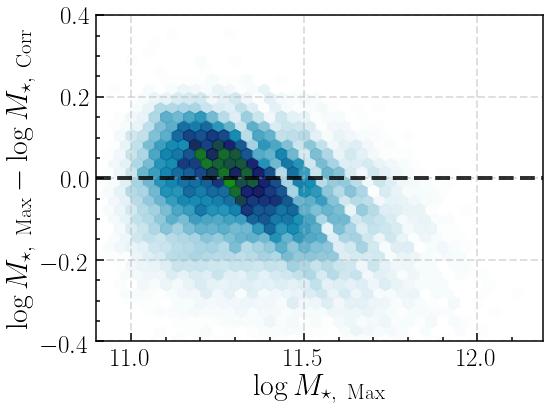

In [73]:
# Test the correction
idx_test = np.digitize(gal_oned['logm_aper'], logm_bin)
logm_test = np.full(len(gal_oned), np.nan)

for k in range(len(logm_bin)):
    logm_test[idx_test == k] = gal_oned['logm_aper'][idx_test == k] + med_diff[k]
    
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(gal_oned['logm_max'], logm_test - gal_oned['logm_max'],
           alpha=0.9, gridsize=(45, 30), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(10.9, 12.19)
_ = ax1.set_ylim(-0.4, 0.4)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm Max}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm Corr}$', fontsize=30)

In [74]:
### Assign corrected mass to aperture sample
idx_aper = np.digitize(gal_aper['logm_aper'], logm_bin)

for k in range(len(logm_bin)):
    gal_aper['logm_best'][idx_aper == k] = gal_aper['logm_aper'][idx_aper == k] + med_diff[k]
    gal_aper['sigm_extra'][idx_aper == k] = std_diff[k]
    
flag_massive = ~np.isfinite(gal_aper['logm_best'])
gal_aper['logm_best'][flag_massive] = gal_aper['logm_aper'][flag_massive] + med_diff[-1] 
gal_aper['sigm_extra'][flag_massive] = std_diff[-1] 

In [75]:
# Combine the samples
logm_comb = vstack([gal_oned, gal_cmod, gal_aper])
logm_comb.sort('z_best')

print((logm_comb['logm_best'] > 0).sum(), len(logm_comb))

684047 684047


In [80]:
print((logm_comb['logm_best'] >= 11.5).sum(), (logm_comb['logm_max'] >= 11.5).sum())
print((logm_comb['logm_best'] >= 11.6).sum(), (logm_comb['logm_max'] >= 11.6).sum())

12166 6481
6249 3156


In [83]:
(~np.isfinite(logm_comb['logm_max']) & (logm_comb['logm_cmod'] >= 11.7)).sum()

374

In [84]:
logm_comb.add_column(Column(data=np.asarray(logm_comb['logm_max']), name='logm_best_cmod'))

logm_comb['logm_best_cmod'][~np.isfinite(logm_comb['logm_max'])] = 0.1 + logm_comb['logm_cmod'][~np.isfinite(logm_comb['logm_max'])]

In [86]:
logm_comb.write('/Users/song/Dropbox/work/temp/s16a_stellar_mass_combined.fits', overwrite=True)

### Training a model

In [180]:
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from gplearn.genetic import SymbolicRegressor

np.random.seed(6564)

#### kNN

In [153]:
X = np.stack(
        [logm_1d_use['logm_cmod'], logm_1d_use['logm_aper'],
         logm_1d_use['tau_ised'], logm_1d_use['z_best'],
         logm_1d_use['gcmodel_mag'] - logm_1d_use['icmodel_mag'], 
         logm_1d_use['amag_g_ised'] - logm_1d_use['amag_i_ised'] 
        ]
    ).T

y = np.asarray(logm_1d_use['logm_max'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [154]:
# kNN regressor: does not work very well
n_neighbors = 30
knn_dist= neighbors.KNeighborsRegressor(n_neighbors, weights='uniform', leaf_size=5,
                                        algorithm='ball_tree', p=1)

y_knn_dist = knn_dist.fit(X_train, y_train)

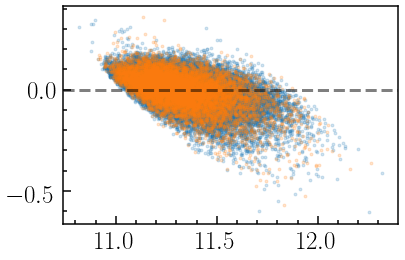

In [155]:
plt.scatter(y_train, knn_dist.predict(X_train) - y_train, alpha=0.2, s=8)
plt.scatter(y_test, knn_dist.predict(X_test) - y_test, alpha=0.2, s=8)
plt.axhline(0.0, alpha=0.5, linewidth=3.0, linestyle='--', c='k')

#### Random forest

In [175]:
X = np.stack(
        [logm_1d_use['logm_aper'], logm_1d_use['logm_cmod'],
         logm_1d_use['tau_ised'], logm_1d_use['z_best'],
        ]
    ).T

y = np.asarray(logm_1d_use['logm_max'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [176]:
# Random forest regressor
rf_regr = RandomForestRegressor(
    max_depth=None, random_state=0, n_estimators=50, criterion='mse',
    bootstrap=True, n_jobs=-1)

rf_regr.fit(X_train, y_train)

print(rf_regr.feature_importances_)

[0.62497504 0.25391819 0.04777615 0.07333063]


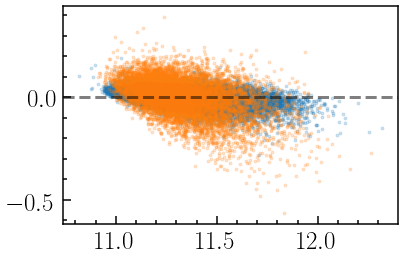

In [177]:
plt.scatter(y_train, rf_regr.predict(X_train) - y_train, alpha=0.2, s=8)
plt.scatter(y_test, rf_regr.predict(X_test) - y_test, alpha=0.2, s=8)
plt.axhline(0.0, alpha=0.5, linewidth=3.0, linestyle='--', c='k')

#### Symbolic regression

In [178]:
X = np.stack(
        [logm_1d_use['logm_aper'], logm_1d_use['logm_cmod'],
         logm_1d_use['tau_ised'], logm_1d_use['z_best'],
        ]
    ).T

y = np.asarray(logm_1d_use['logm_max'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [181]:
est_gp = SymbolicRegressor(population_size=10000,
                           generations=50, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.60      1.41903e+08       23        0.0774233        0.0780933     46.69m
   1    10.97          71.4357       23        0.0773634        0.0786318     23.04m
   2     5.36          35.3243       23        0.0773999        0.0783038     18.49m
   3     1.80          10.5168        3        0.0896742        0.0916027     14.93m
   4     1.53          5.35158        3        0.0901004        0.0902805     13.80m
   5     1.50          894.456        3        0.0894842        0.0907542     14.00m
   6     1.50          3014.05        3         0.102159         0.103628     13.65m
   7     1.49          95.1743        3        0.0934315        0.0925101     13.64m
   8     1.53          97.2353        3        0.0906754        0.0890712  

SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div'), generations=50,
                  init_depth=(2, 6), init_method='half and half',
                  low_memory=False, max_samples=0.9,
                  metric='mean absolute error', n_jobs=1, p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=10000,
                  random_state=0, stopping_criteria=0.001, tournament_size=20,
                  verbose=1, warm_start=False)

In [182]:
print(est_gp._program)

add(sub(X0, X2), add(0.294, X2))


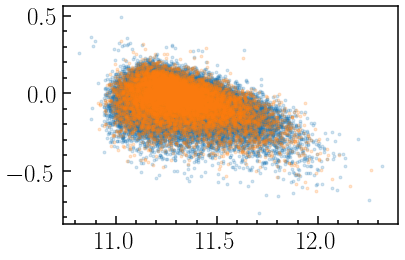

In [183]:
plt.scatter(y_train, est_gp.predict(X_train) - y_train, alpha=0.2, s=8)

plt.scatter(y_test, est_gp.predict(X_test) - y_test, alpha=0.2, s=8)